In [1]:
import gym
import minerl

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature

import os

from mission_util import create_mission, INTERESTING_COORDS


import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam, Adagrad
from gym.spaces import Discrete, Box

C:\Users\georg\anaconda3\envs\minerl\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
mission_name = "outsideToEntranceDense"
create_mission(start_coords=INTERESTING_COORDS["outside_close_to_entrance"],
               goal_coords=INTERESTING_COORDS["inside_entrance"],
               mission_name=mission_name,
               dense=True)

In [3]:
%run parse_missions

In [4]:
#import logging
#logging.basicConfig(level=logging.DEBUG)

In [5]:
xml_path = os.path.join("my_mission_xmls", mission_name + ".xml")
env = gym.make("MineRLNavigate-v0", xml=xml_path)

In [6]:
# set the environment to allow interactive connections on port 6666
# and slow the tick speed to 6666.
# env.make_interactive(port=6666, realtime=True)

In [7]:
obs = env.reset()

(64, 64)


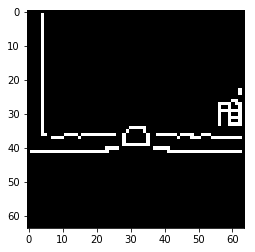

In [8]:
im = obs["pov"][..., 0]
edges = feature.canny(im, sigma=1)
plt.imshow(edges, cmap=plt.cm.gray)
print(im.shape)

In [9]:
#adapted from 
#https://github.com/openai/spinningup/blob/master/spinup/examples/pytorch/pg_math/1_simple_pg.py
def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def train(env, logits_net = None, hidden_sizes=[32], lr=1e-2,
          epochs=50, max_steps_per_epoch=30, 
          batch_size=5000, min_episodes_per_epoch=0, render=False):

    
    def compress_obs(obs, pov_channel=0, canny_sigma=1.):
        angle = obs["compassAngle"]
        im = obs["pov"][..., pov_channel]
        #im = feature.canny(im, sigma=canny_sigma)
        obs = np.append(im.flatten(), angle)
        return obs

    obs_dim = 1 + obs["pov"].shape[0] * obs["pov"].shape[1]
    actions = [{"forward" : 1, "camera" : [0, 0]},
                {"camera" : [0, 90]}]
    n_acts = len(actions)

    # make core of policy network
    if logits_net is None:
        logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

    # make function to compute action distribution
    def get_policy(obs):
        logits = logits_net(obs)
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        logp = get_policy(obs).log_prob(act)
        return -(logp * weights).mean()

    # make optimizer
    optimizer = Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        obs = compress_obs(obs)
                    
        if render:
            env.render()
        
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep


        # collect experience by acting in the environment with current policy
        nbr_actions = 0
        while True:


            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            act = get_action(torch.as_tensor(obs, dtype=torch.float32))
            nbr_actions += 1
            
            obs, rew, done, _ = env.step(actions[act])
            obs = compress_obs(obs)
            
            if render:
                env.render()

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)

            if nbr_actions >= max_steps_per_epoch or done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a|s) is R(tau)
                batch_weights += [ep_ret] * ep_len

                # reset episode-specific variables
                obs, done, ep_rews, nbr_actions = env.reset(), False, [], 0
                obs = compress_obs(obs)

                # end experience loop if we have enough of it
                if (len(batch_obs) > batch_size) and \
                  (len(batch_rets) >= min_episodes_per_epoch):
                    break

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                                  act=torch.as_tensor(batch_acts, dtype=torch.int32),
                                  weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                                  )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_lens

    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        print(('epoch: %3d \t loss: %.3f \t avg_return: %.3f' +
                '\t avg_episode_len: %.3f \t epoch_len: %3d')%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens), len(batch_rets)))
        
    return logits_net

In [ ]:
learning_rate = 1e-2
epochs = 5
batch_size = 500
max_steps_per_epoch=100

mlp = train(env=env, render=False, lr=learning_rate,
          epochs=epochs, max_steps_per_epoch=max_steps_per_epoch,
          batch_size=batch_size)

epoch:   0 	 loss: -0.630 	 avg_return: -0.983	 avg_episode_len: 100.000 	 epoch_len:   6


In [ ]:
#env.close()